# Final Exercice: The Rumos Bank 

The Rumos Bank é um banco que tem perdido bastante dinheiro devido à quantidade de créditos que fornece e que não são pagos dentro do prazo devido. 

    - Por cada cliente que se estima que não irá  pagar dentro do prazo e afinal paga, o banco tem um custo de 1000euros. 

    - Por cada cliente que se prevê como sendo um bom pagador e afinal não paga dentro do prazo, o banco tem um custo de 3000euros.


Vocês, data scientists de topo,  são contratados para ajudar o banco a prever quais os clientes que não irão cumprir os prazos, para que este consiga uma melhor gestão dos fundos.

Conseguem construir um modelo que ajude a detectar previamente e com sucesso os clientes que são maus pagadores?


Dataset: https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

Variáveis disponíveis:

    ID: ID of each client
    LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
    SEX: Gender (1=male, 2=female)
    EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
    MARRIAGE: Marital status (1=married, 2=single, 3=others)
    AGE: Age in years
    PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
    PAY_2: Repayment status in August, 2005 (scale same as above)
    PAY_3: Repayment status in July, 2005 (scale same as above)
    PAY_4: Repayment status in June, 2005 (scale same as above)
    PAY_5: Repayment status in May, 2005 (scale same as above)
    PAY_6: Repayment status in April, 2005 (scale same as above)
    BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
    BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
    BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
    BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
    BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
    BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
    PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
    PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
    PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
    PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
    PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
    PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
    default.payment.next.month: Default payment (1=yes, 0=no)

#### Perguntas:

    1. Quantas features estão disponíveis? Quantos clientes?
    2. Quantos clientes têm no dataset que efectivamente foram maus pagadores? E quantos não foram?
    3. Qual o modelo que levou a melhores resultados? Qual a métrica usada para comparar os diferentes modelos?
    4. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para ser mau pagador?
    5. Qual seria o custo que o banco tem sem nenhum modelo?
    6. Qual o custo que o banco passa a tar com o vosso modelo?

Com base na informação dada, podemos definir que:

    True positive - Os maus pagadores são identificados correctamente.
    True negative - Os bons pagadores são identificados correctamente.
    False positive - Um bom pagador é identificado como sendo um mau pagador.
    False negative - Um mau pagador é identificado como sendo um bom pagador.

In [3]:
root_path = '../data/'

In [4]:
# Install missing packages
#%pip install pandas numpy matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn
import json

seed = 42

# Carregar configuração do MLflow do arquivo config/app.json
with open('../config/app.json', 'r') as f:
    config = json.load(f)

# Atualizar a URL do MLflow para usar localhost
mlflow_uri = config['mlflow']['tracking_uri'].replace('mlflow-tracking-server', 'localhost')

# Configurar MLflow para usar o servidor remoto
mlflow.set_tracking_uri(mlflow_uri)
mlflow.set_experiment("bank_lending_prediction")

<Experiment: artifact_location='file:../mlruns/1', creation_time=None, experiment_id='1', last_update_time=None, lifecycle_stage='active', name='bank_lending_prediction', tags={}>

In [5]:
df = pd.read_csv(root_path + 'lending_data.csv')

In [6]:
df.shape

(30000, 25)

In [7]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [8]:
df.ID.nunique()

30000

#### 1. Quantas features estão disponíveis? Quantos clientes?

    - Existem 24 features disponíveis no dataset.
    - Existem 30000 clientes.

Existem missing values?

In [9]:
df.isnull().values.any()

False

Existem o mesmo número de clientes nas duas classes?

In [10]:
df.groupby('default.payment.next.month')['default.payment.next.month'].count()

default.payment.next.month
0    23364
1     6636
Name: default.payment.next.month, dtype: int64

Não! O dataset é altamente desequilibrado.

#### 2. Quantos clientes têm no dataset que efectivamente foram maus pagadores? E quantos não foram?

    - 23,364 foram bons pagadores. 6,636 foram maus pagadores.

Existem features não númericas?

In [11]:
df.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

Todas as features são númericas.

Vamos retirar o ID do cliente:

In [12]:
df = df.drop('ID', axis = 1)

Vamos então dividir o dataset em treino e teste:

In [13]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = seed)

In [14]:
X_train = train_set.drop(['default.payment.next.month'], axis = 'columns')
y_train = train_set['default.payment.next.month']

X_test = test_set.drop(['default.payment.next.month'], axis = 1)
y_test = test_set['default.payment.next.month']

Normalização:

In [15]:
scaler = MinMaxScaler()

features_names = X_train.columns

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = features_names)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = features_names)

Antes de iniciar, vamos calcular a baseline, ou seja, o custo que temos sem nenhum modelo.

$$totalCost = 1000∗FP+3000∗FN$$

In [16]:
y_preds_all_bad = np.ones(y_test.shape) 

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_bad).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 0
Number of True Positives: 1313
Number of False Negatives: 0
Number of False Positives: 4687


In [18]:
print('Total Cost:', fp*1000)

Total Cost: 4687000


In [19]:
accuracy_score(y_test, y_preds_all_bad)

0.21883333333333332

Se todos os clientes fossem considerados como maus pagadores, o banco teria um custo de 4,687,000 Euros.

In [20]:
y_preds_all_good = np.zeros(y_test.shape) 

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_good).ravel()

print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)

Number of True Negatives: 4687
Number of True Positives: 0
Number of False Negatives: 1313
Number of False Positives: 0


In [21]:
print('Total Cost:', fn*3000)

Total Cost: 3939000


In [22]:
accuracy_score(y_test, y_preds_all_good)

0.7811666666666667

Se todos os clientes fossem considerados bons pagadores, o banco teria um custo de 3,939,000 Euros.

In [23]:
def total_cost(y_test, y_preds, threshold = 0.5):
    
    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()
    
    cost_fn = fn*3000
    cost_fp = fp*1000
    
    return cost_fn + cost_fp
    

In [24]:
def min_cost_threshold(y_test, y_preds):
    
    costs = {}
    
    for threshold in np.arange(0, 1.1, 0.1):
        
        costs[round(threshold, 1)] = total_cost(y_test, y_preds, threshold = threshold)
        
    plt.plot(list(costs.keys()), list(costs.values()))
    plt.ylabel('Cost')
    plt.xlabel('Threshold')
    plt.show()
    

#### Logistic Regression

In [25]:
%%time
lr = LogisticRegression(max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' )

parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

clf_lr = GridSearchCV(lr, parameters, cv = 5).fit(X_train, y_train)

CPU times: user 40.1 s, sys: 43.5 s, total: 1min 23s
Wall time: 38.9 s


In [26]:
clf_lr.score(X_test, y_test)

0.6936666666666667

In [27]:
y_preds = clf_lr.predict_proba(X_test)[:,1]

In [28]:
total_cost(y_test, y_preds, threshold = 0.5)

2852000

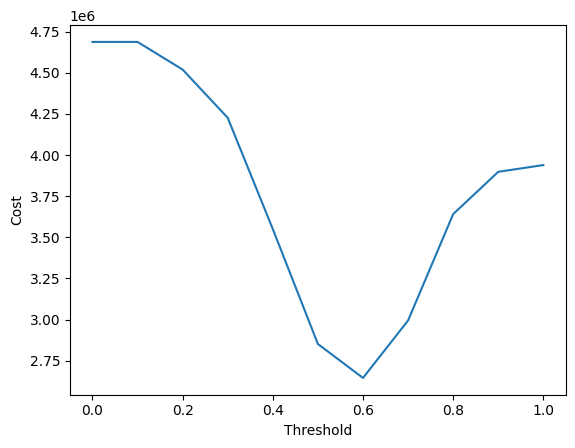

In [29]:
min_cost_threshold(y_test, y_preds)

In [30]:
total_cost(y_test, y_preds, threshold = 0.6)

2646000

O Custo é minimo para um threshold de 0.6: 2,646,000 Euros, que é a melhor que a baseline!

#### KNN

In [31]:
%%time
knn = KNeighborsClassifier()

parameters = {'n_neighbors': range(1,10, 1)}

clf_knn = GridSearchCV(knn, parameters, cv = 5).fit(X_train, y_train)

CPU times: user 22.5 s, sys: 16.5 s, total: 39 s
Wall time: 19.6 s


KNN não é um metodo adequado para grandes datasets! Vamos ver se compensa a nível de resultados:

In [32]:
y_preds = clf_knn.predict_proba(X_test)[:,1]

clf_knn.score(X_test, y_test)

0.807

In [33]:
total_cost(y_test, y_preds, threshold = 0.5)

2900000

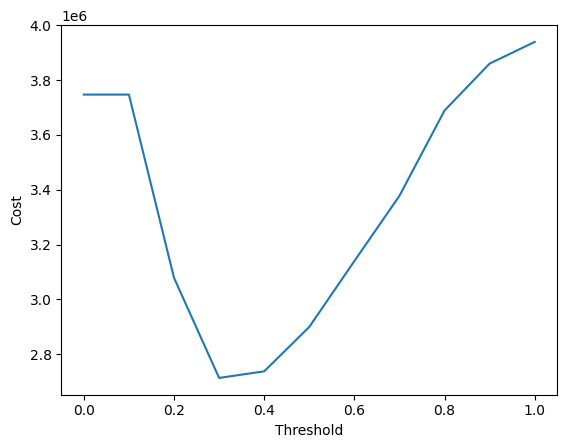

In [34]:
min_cost_threshold(y_test, y_preds)

In [35]:
total_cost(y_test, y_preds, threshold = 0.3)

2714000

Melhor que a baseline mas pior que usar regressão logistica.

#### SVM

%%time

svc = SVC(random_state = seed, class_weight = 'balanced', gamma = 'scale', probability = True, verbose = True)

parameters = {'C':[0.1, 1, 10], 'kernel': ('rbf', 'linear') }

clf_svc = GridSearchCV(svc, parameters, cv = 5).fit(X_train, y_train)

In [36]:
#y_preds = clf_svc.predict_proba(X_test)[:,1]

In [37]:
#clf_svc.score(X_test, y_test)

In [38]:
#total_cost(y_test, y_preds, threshold = 0.5)

In [39]:
#min_cost_threshold(y_test, y_preds)

In [40]:
#total_cost(y_test, y_preds, threshold = 0.3)

Melhor valor até agora!

#### Decision Trees

In [41]:
%%time

trees = tree.DecisionTreeClassifier(random_state = seed,  class_weight = 'balanced')

parameters = {'max_depth':[3, 6], 'min_samples_split': [2, 4, 8, 10]}

clf_tree = GridSearchCV(trees, parameters, cv = 5).fit(X_train, y_train)

CPU times: user 2.42 s, sys: 2.44 s, total: 4.86 s
Wall time: 4.98 s


In [42]:
clf_tree.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42)

In [43]:
y_preds = clf_tree.predict_proba(X_test)[:,1]

clf_tree.score(X_test, y_test)

0.7608333333333334

In [44]:
total_cost(y_test, y_preds, threshold = 0.5)

2581000

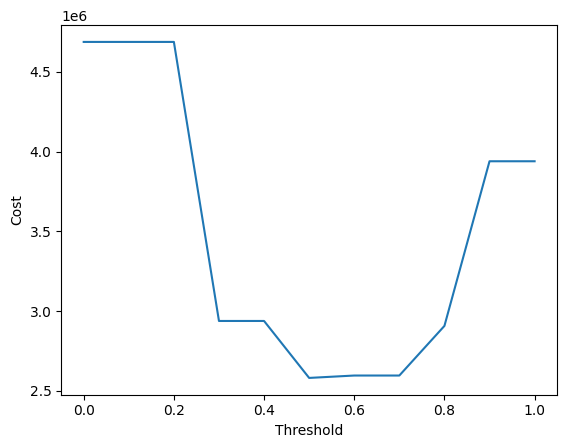

In [45]:
min_cost_threshold(y_test, y_preds)

In [46]:
total_cost(y_test, y_preds, threshold = 0.5)

2581000

SVMs continuam a ganhar.

#### Random Forests

In [47]:
%%time 
rf = RandomForestClassifier(random_state = seed,  class_weight = 'balanced').fit(X_train, y_train)

parameters = {'n_estimators':[10, 100, 200, 500]}

clf_rf = GridSearchCV(rf, parameters, cv = 5).fit(X_train, y_train)

CPU times: user 8min 35s, sys: 0 ns, total: 8min 35s
Wall time: 8min 40s


In [48]:
y_preds = clf_rf.predict_proba(X_test)[:,1]

clf_rf.score(X_test, y_test)

0.8145

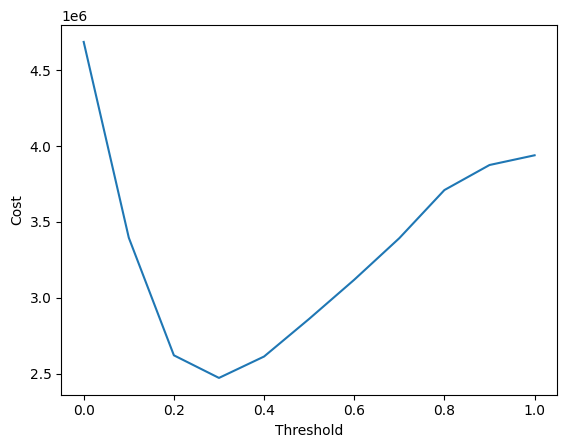

In [49]:
min_cost_threshold(y_test, y_preds)

In [50]:
total_cost(y_test, y_preds, threshold = 0.3)

2472000

Melhor resultado até agora!

#### Neural Networks

In [51]:
#X_train.shape

In [52]:
#%%time

#mlp = MLPClassifier(solver = 'lbfgs',  random_state = seed, max_iter = 1000 )

#parameters = {'hidden_layer_sizes': [(20,), (20,10), (20, 10, 2)], 'learning_rate_init':[0.0001, 0.001, 0.01, 0.1]}

#clf_mlp = GridSearchCV(mlp, parameters, cv = 5).fit(X_train, y_train)

In [53]:
#clf_mlp.best_estimator_

In [54]:
#clf_mlp.best_score_

In [55]:
#y_preds = clf_mlp.predict_proba(X_test)[:,1]

#clf_mlp.score(X_test, y_test)


In [56]:
#min_cost_threshold(y_test, y_preds)

In [57]:
#total_cost(y_test, y_preds, threshold = 0.2)

Resultado quase igual às random forests!

#### 3. Qual o modelo que levou a melhores resultados? Qual a métrica usada para comparar os diferentes modelos?

- A métrica usada foi o custo total uma vez que o objetivo do modelo era diminuir os custos do banco. O Modelo que levou a melhores resultados foram as neural networks e as random forests - 2,467,000 de custo.  
- Visto que com as neural networks não consigo saber qual a importancia das features, vou eleger o modelo de random forests como a solução final. Para além disso o treino das neural networks demorou quase o dobro do tempo.

#### 4. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para ser mau pagador?

In [58]:
rf = RandomForestClassifier(**clf_rf.best_params_).fit(X_train, y_train)

In [59]:
important_features = pd.DataFrame(data = rf.feature_importances_, index = X_train.columns, columns = ['value'])
important_features.sort_values(by = 'value', ascending = False)

,value
PAY_0,0.096084
AGE,0.066330
BILL_AMT1,0.060256
LIMIT_BAL,0.059714
BILL_AMT2,0.054251
BILL_AMT3,0.051250
PAY_AMT1,0.051185
BILL_AMT4,0.050700
BILL_AMT6,0.050233
BILL_AMT5,0.049703


As variaveis que mais contribuem para o modelo decidir se um cliente vai ser um bom ou mau pagador são:
    - PAY_0 - Repayment status in September, 2005 
    - e AGE - idade do cliente
    

#### 5. Qual seria o custo que o banco tem sem nenhum modelo?

    - O custo que o banco teria sem modelo, ou seja, assumindo que todos os clientes seriam bons pagadores, é de: 3,939,000 Euros.

#### 6. Qual o custo que o banco passa a tar com o vosso modelo?

- O custo que o banco teria com o modelo seria de: 2,476,000 Euros - Pouparia quase 1 Milhão e meio de Euros!

## Avaliação dos Modelos com MLflow

Vamos agora avaliar todos os modelos usando MLflow para rastrear as experiências e comparar seu desempenho.

## Funções de Suporte para MLflow

In [60]:
def create_model_pipeline(model_class, **params):
    return Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model_class(**params))
    ])

def train_model_with_mlflow(pipeline, model_name, X_train, y_train, X_test, y_test, params, threshold=0.5):
    with mlflow.start_run(run_name=model_name) as run:
        # Treinar o modelo
        pipeline.fit(X_train, y_train)
        
        # Fazer previsões
        y_pred_proba = pipeline.predict_proba(X_test)[:,1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Calcular métricas
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'total_cost': total_cost(y_test, y_pred_proba, threshold=threshold)
        }
        
        # Registrar parâmetros
        mlflow.log_params(params)
        
        # Registrar métricas
        mlflow.log_metrics(metrics)
        
        # Registrar o modelo
        mlflow.sklearn.log_model(pipeline, "model")
        
        # Se for RandomForest, registrar importância das features
        if model_name == 'RandomForest':
            feature_importance = pd.DataFrame(
                pipeline.named_steps['model'].feature_importances_,
                index=X_train.columns,
                columns=['importance']
            ).sort_values('importance', ascending=False)
            
            # Plot feature importance
            plt.figure(figsize=(10, 6))
            plt.bar(range(len(feature_importance)), feature_importance['importance'])
            plt.xticks(range(len(feature_importance)), feature_importance.index, rotation=45)
            plt.tight_layout()
            plt.savefig('feature_importance.png')
            mlflow.log_artifact('feature_importance.png')
            plt.close()
        
        return pipeline, metrics, run.info.run_id

In [61]:
# Criar pipelines para cada modelo
model_pipelines = {}

# Logistic Regression Pipeline
lr_params = {
    'max_iter': 500,
    'solver': 'lbfgs',
    'class_weight': 'balanced',
    'C': clf_lr.best_params_['C']
}
model_pipelines['LogisticRegression'] = create_model_pipeline(LogisticRegression, **lr_params)

# Random Forest Pipeline
rf_params = {
    'n_estimators': clf_rf.best_params_['n_estimators'],
    'class_weight': 'balanced'
}
model_pipelines['RandomForest'] = create_model_pipeline(RandomForestClassifier, **rf_params)

# Neural Network Pipeline
#nn_params = {
#    'solver': 'lbfgs',
#    'max_iter': 1000,
#    'hidden_layer_sizes': clf_mlp.best_params_['hidden_layer_sizes'],
#    'learning_rate_init': clf_mlp.best_params_['learning_rate_init']
#}
#model_pipelines['NeuralNetwork'] = create_model_pipeline(MLPClassifier, **nn_params)

# Decision Tree Pipeline
dt_params = {
    'max_depth': clf_tree.best_params_['max_depth'],
    'min_samples_split': clf_tree.best_params_['min_samples_split'],
    'class_weight': 'balanced'
}
model_pipelines['DecisionTree'] = create_model_pipeline(tree.DecisionTreeClassifier, **dt_params)

In [62]:
# Treinar e avaliar cada modelo com MLflow
results = {}

for model_name, pipeline in model_pipelines.items():
    print(f"\nTreinando {model_name}...")
    
    # Treinar modelo e registrar no MLflow
    model, metrics, run_id = train_model_with_mlflow(
        pipeline,
        model_name,
        X_train, y_train,
        X_test, y_test,
        params=pipeline.get_params(),
        threshold=0.5
    )
    
    results[model_name] = {
        'metrics': metrics,
        'run_id': run_id
    }
    
    print(f"Métricas para {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Treinando LogisticRegression...


PermissionError: [Errno 13] Permission denied: '../mlruns/1/b767a242b6934cd896d02d62a62c2ca8/artifacts/model'

In [ ]:
# Encontrar o melhor modelo baseado no custo total
best_model = min(results.items(), key=lambda x: x[1]['metrics']['total_cost'])
print(f"\nMelhor modelo: {best_model[0]}")
print(f"Custo total: {best_model[1]['metrics']['total_cost']:.2f}")
print(f"Run ID: {best_model[1]['run_id']}")

# Carregar o melhor modelo do MLflow
best_model_uri = f"runs:/{best_model[1]['run_id']}/model"
best_model_loaded = mlflow.sklearn.load_model(best_model_uri)

# Salvar o melhor modelo como o modelo final
with mlflow.start_run(run_name=f"final_{best_model[0]}") as run:
    mlflow.sklearn.log_model(best_model_loaded, "final_model")
    print(f"\nModelo final salvo com run_id: {run.info.run_id}")


Melhor modelo: DecisionTree
Custo total: 2581000.00
Run ID: af22f9441e9e4d09b5e3363cb5e93fbc

Modelo final salvo com run_id: cd0fe3c69b2c437aa3d71e8f3b4e5de4


## Registrando o Modelo Campeão

Agora vamos registrar nosso melhor modelo no MLflow Model Registry e marcá-lo como 'champion'.

In [ ]:
# Registrar o melhor modelo no Model Registry
model_name = "bank_lending_model"
model_version = mlflow.register_model(
    f"runs:/{best_model[1]['run_id']}/model",
    model_name
)

# Transicionar o modelo para o estágio 'Production' (champion)
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage="Production"
)

print(f"Modelo {model_name} versão {model_version.version} registrado e marcado como Production/Champion")

## Configurando MLflow Remote Server

Agora vamos configurar o MLflow para usar um servidor remoto em vez do armazenamento local.

In [ ]:
# Verificar configuração atual do MLflow
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")